In [31]:
from embedding.data import ImageTextDataset, ImageTextDataCollator
from embedding.model import TextModelEmbedding, ImageModelEmbedding
from pathlib import Path
import torch
from PIL import Image
from tqdm.auto import tqdm
import numpy as np 
import pandas as pd 
from typing import List

In [2]:
small_data = ImageTextDataset('small', 'en')
len(small_data)

loading text data:   0%|          | 0/10000 [00:00<?, ?it/s]

10000

In [3]:
small_data[0]

ImageTextData(image_path=PosixPath('data/jackyhate/text-to-image-2M/data_1024_10K/flux_1024_10k_00002490.jpg'), text="A vintage movie poster featuring three actors from the 1930s film 'The Roaring Twenties'. The poster has a red background with white text and a yellow border. The actors are depicted in a stylized manner, with exaggerated facial features and poses. The title of the film is prominently displayed at the top, and the names of the actors are listed at the bottom. The poster has a classic, nostalgic feel, reminiscent of the era in which the film was made.", other={'prompt': "A vintage movie poster featuring three actors from the 1930s film 'The Roaring Twenties'. The poster has a red background with white text and a yellow border. The actors are depicted in a stylized manner, with exaggerated facial features and poses. The title of the film is prominently displayed at the top, and the names of the actors are listed at the bottom. The poster has a classic, nostalgic feel, rem

In [ ]:
text_embedding_model_path = "models/BAAI/bge-large-zh-v1.5"
image_embedding_model_path = "models/train_v1205/model_image-gpu2-large-zh-custom"
device = "cuda:0"

text_embedding_model = TextModelEmbedding(text_embedding_model_path, device)
image_embedding_model = ImageModelEmbedding(image_embedding_model_path, device)




In [7]:
image_text_data_collator = ImageTextDataCollator(
    image_size=image_embedding_model.model.config.image_size,
    mean=image_embedding_model.image_processor.image_mean,
    std=image_embedding_model.image_processor.image_std,
    tokenizer=None,
    max_seq_length=None,
)

In [32]:
def convert_image2embedding(image: Path | List[Path], normalize: bool = True):

    if not isinstance(image, List):
        images = [image]
    else:
        images = image

    with torch.inference_mode():
        pixel_values_list = [
            image_text_data_collator.transform_image(image_) for image_ in images
        ]#.unsqueeze(0)
        # print(pixel_values.shape)
        pixel_values = {"pixel_values": torch.stack(pixel_values_list)}
        embedding_value = (
            image_embedding_model(
                encoded_input=pixel_values, images=None, normalize_embeddings=normalize
            )
            .cpu()
            .numpy()
        )
        # image_embedding = image_embedding_model(image)
        return embedding_value


convert_image2embedding(small_data[0].image_path)

array([[-0.00064389,  0.01441428, -0.02930374, ...,  0.01187305,
        -0.04066178,  0.01411109]], dtype=float32)

In [20]:
def convert_text2embedding(text: str, normalize: bool = True):
    with torch.inference_mode():

        text = text_embedding_model(
            encoded_input=None, sentences=[text], normalize_embeddings=normalize
        ).cpu().numpy()
        return text


convert_text2embedding(small_data[0].text)

array([[-0.00842262, -0.01245492,  0.0346438 , ..., -0.03194459,
        -0.02350519, -0.04467998]], dtype=float32)

In [ ]:
small_data[1]

ImageTextData(image_path=PosixPath('data/jackyhate/text-to-image-2M/data_1024_10K/flux_1024_10k_00006148.jpg'), text='A stack of white towels is neatly arranged on a wooden tray, with a small bouquet of white flowers in a vase to the left and a single white flower with green leaves on the right. In front of the towels, there are three white stones.', other={'prompt': 'A stack of white towels is neatly arranged on a wooden tray, with a small bouquet of white flowers in a vase to the left and a single white flower with green leaves on the right. In front of the towels, there are three white stones.', 'file_path': 'flux_1024_10k_00006148'})

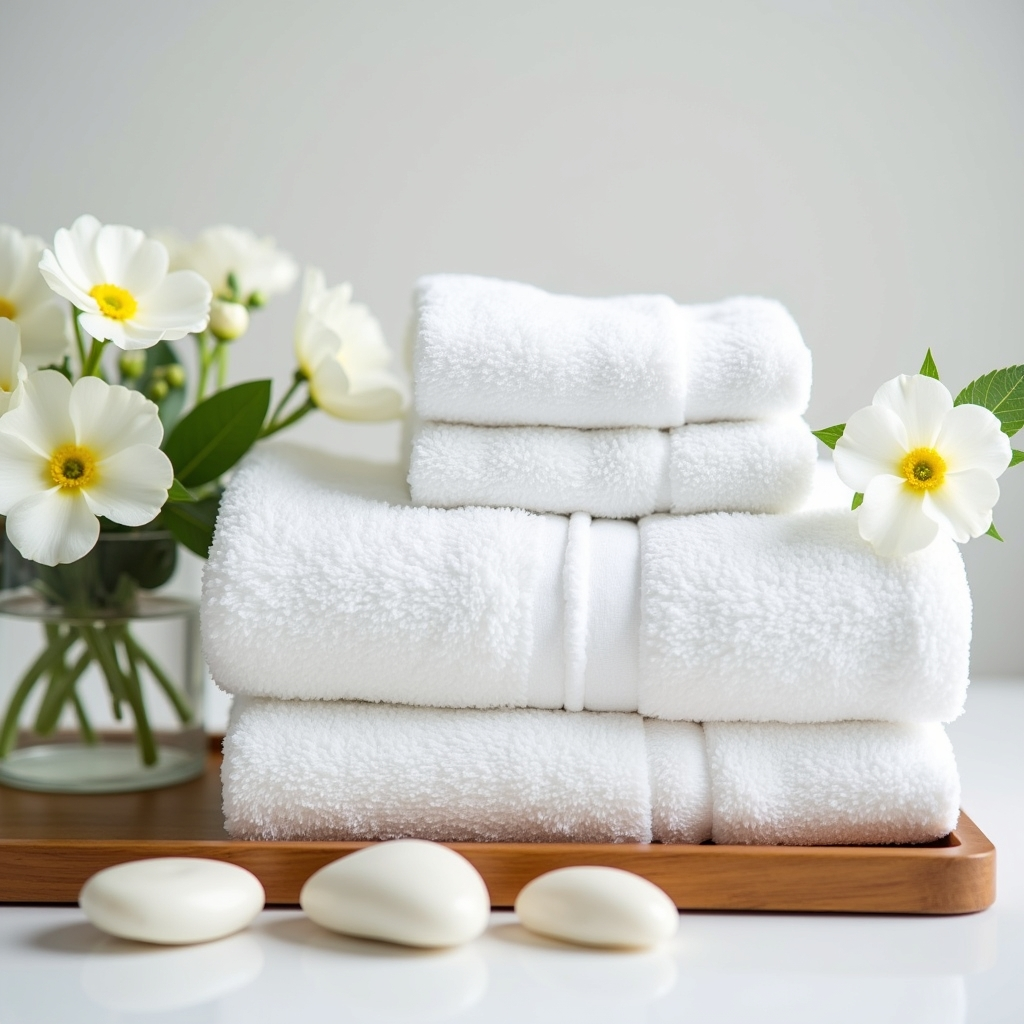

In [ ]:
Image.open(small_data[1].image_path)

In [38]:
all_image_path = [data.image_path for data in small_data]#[:30]
len(all_image_path)

10000

In [40]:
chunk_size = 100

all_image_embedding_vector = np.concatenate([
    convert_image2embedding(all_image_path[index : (index + chunk_size)])
    for index in tqdm(range(0, len(all_image_path), chunk_size))
])
all_image_embedding_vector.shape


  0%|          | 0/100 [00:00<?, ?it/s]

(10000, 1024)

In [67]:
text_embedding_test01 = convert_text2embedding(
    # "西装男士站在一位身穿白色礼服的女士旁边"
    "东西摆放在木质表面"
)


test_df1 = pd.DataFrame({
    "image_path": all_image_path,
    "score": (text_embedding_test01 @ all_image_embedding_vector.T).flatten(),
}).sort_values("score", ascending=False).head(10)

test_df1

image_path     score
6845  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.380294
5234  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.368979
1932  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.364531
6608  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.363459
6687  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.360218
7984  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.360106
3839  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.354832
7603  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.347279
2514  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.345296
5500  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.342968

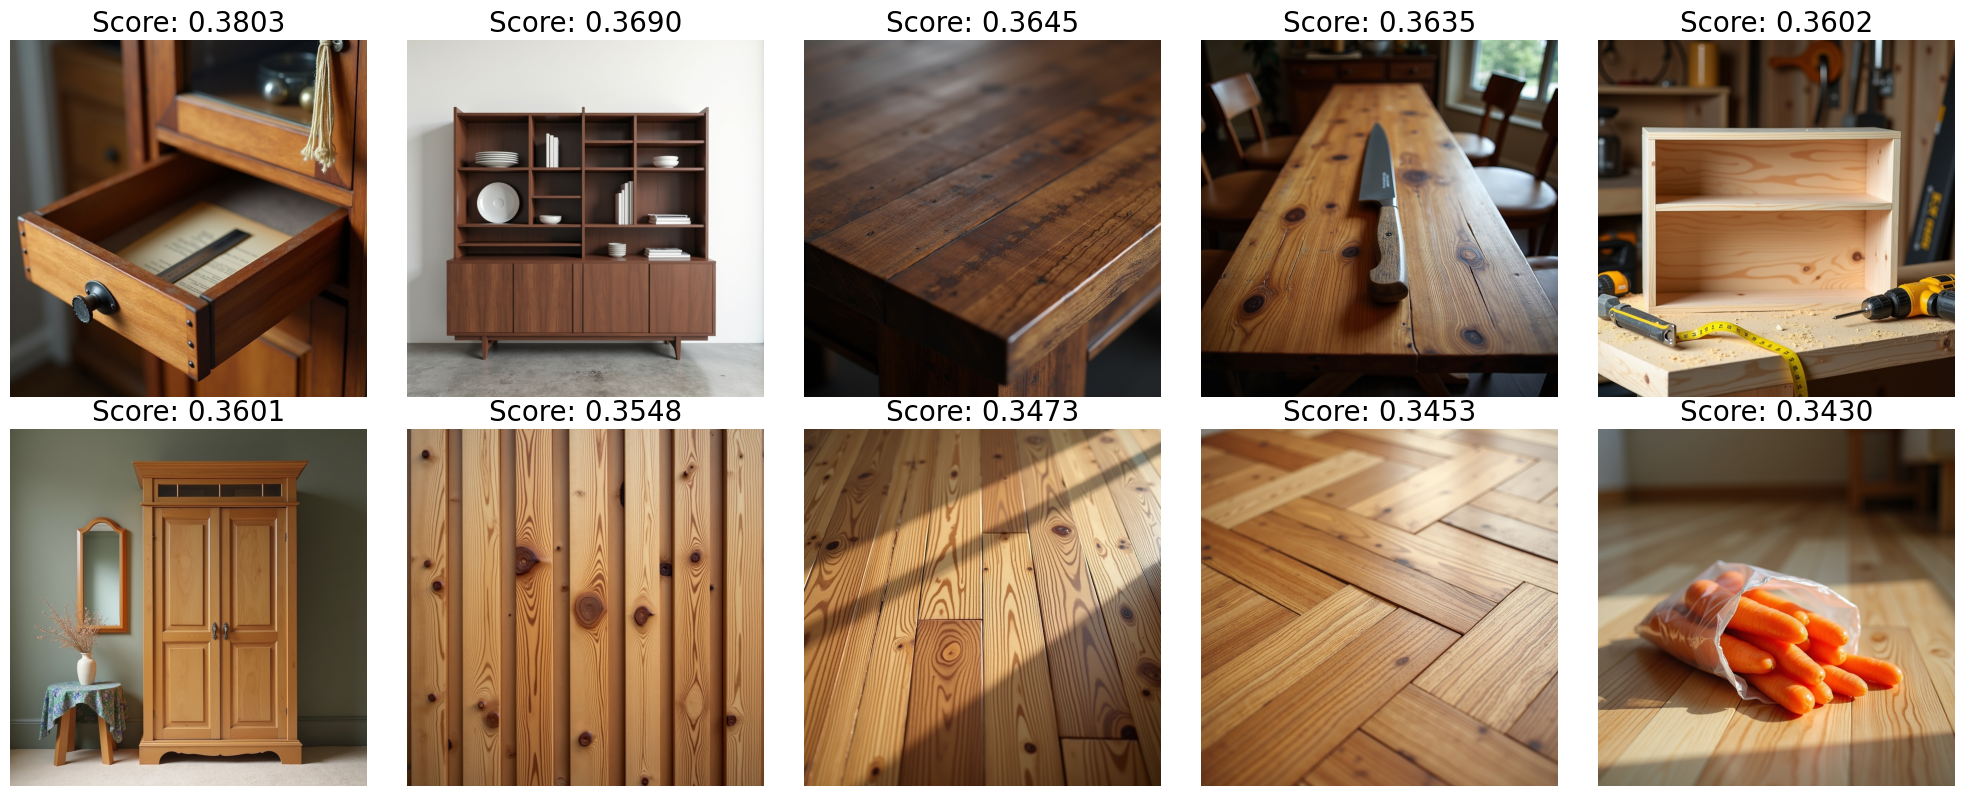

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg


def plot_images_with_scores(images, scores, rows=1, cols=None):
    """
    展示多个图片并显示对应的分数

    参数:
    - images: 图片文件路径列表 (List[Path])
    - scores: 对应的分数列表
    - rows: 行数（默认为1）
    - cols: 列数（默认为None，将自动计算）
    """
    # 如果没有指定列数，自动计算
    if cols is None:
        cols = len(images)

    # 创建图形和子图
    fig, axes = plt.subplots(rows, cols, figsize=(4 * cols, 4 * rows))

    # 如果只有一张图，将axes转换为数组
    if rows == 1 and cols == 1:
        axes = np.array([[axes]])
    elif rows == 1:
        axes = axes.reshape(1, -1)
    elif cols == 1:
        axes = axes.reshape(-1, 1)

    # 遍历并显示图片
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < len(images):
                # 读取图片
                img = mpimg.imread(str(images[idx]))

                # 显示图片
                axes[i, j].imshow(img)
                axes[i, j].axis("off")

                # 添加分数标签
                axes[i, j].set_title(f"Score: {scores[idx]:.4f}", fontsize=20)

    # 调整布局
    plt.tight_layout()
    plt.show()



image_paths = test_df1['image_path'].tolist()

scores = test_df1['score'].tolist()

plot_images_with_scores(image_paths, scores, rows=2, cols=5)



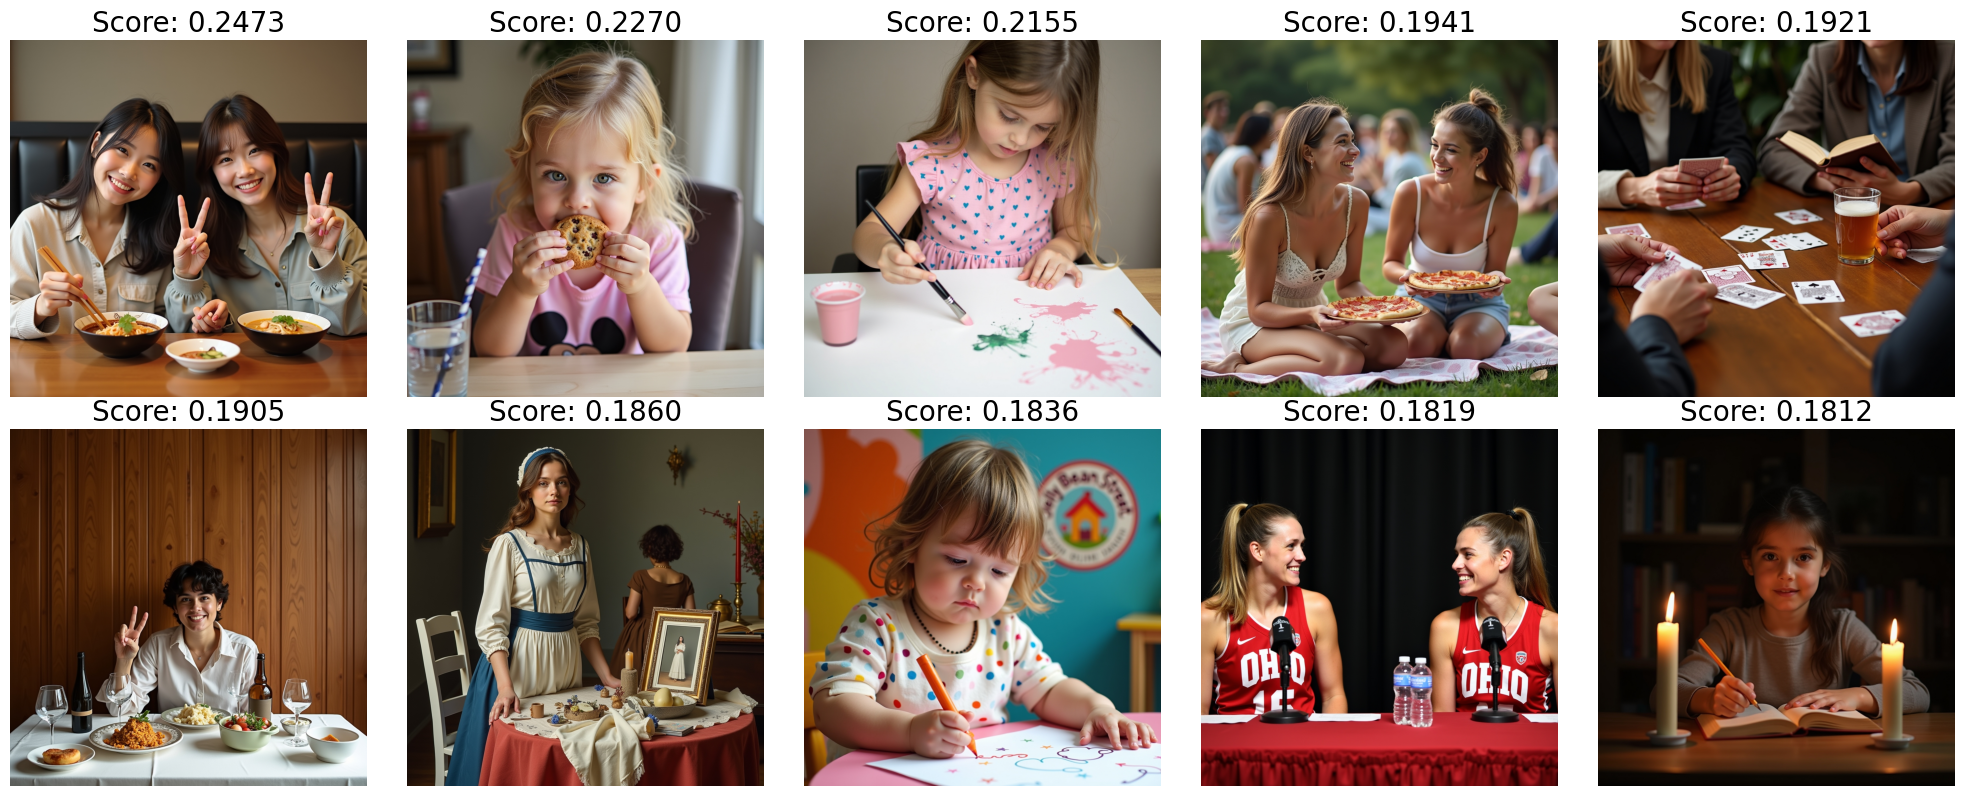

image_path     score
1718  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.247268
7507  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.226952
371   data/jackyhate/text-to-image-2M/data_1024_10K/...  0.215458
2198  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.194088
6124  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.192097
9819  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.190469
7512  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.186031
6482  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.183608
4125  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.181857
1785  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.181234

In [73]:
def search_demo1(text: str, top_k: int = 10):
    text_embedding = convert_text2embedding(text)
    test_df = (
        pd.DataFrame({
            "image_path": all_image_path,
            "score": (text_embedding @ all_image_embedding_vector.T).flatten(),
        })
        .sort_values("score", ascending=False)
        .head(top_k)
    )
    image_paths = test_df["image_path"].tolist()

    scores = test_df["score"].tolist()

    plot_images_with_scores(image_paths, scores, rows=2, cols=5)

    return test_df


search_demo1("一个女孩坐在桌前，面前摆着两张披萨和一杯汽水")


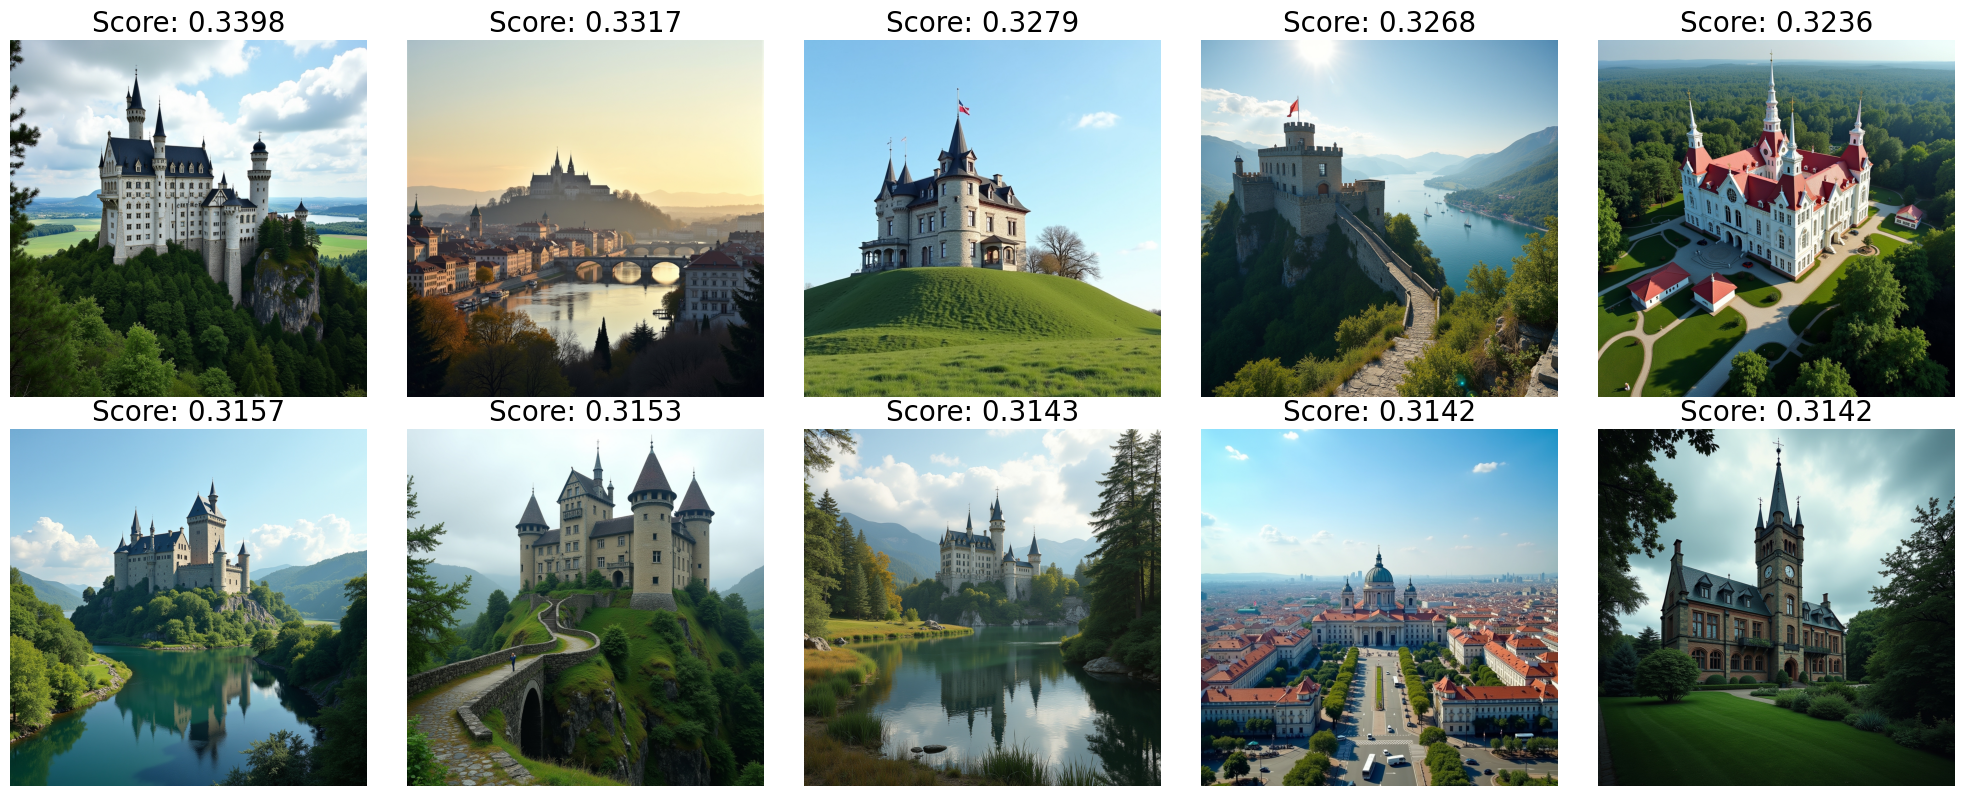

image_path     score
252   data/jackyhate/text-to-image-2M/data_1024_10K/...  0.339805
4949  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.331671
6870  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.327866
9718  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.326849
8013  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.323572
2387  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.315673
5530  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.315270
4417  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.314286
6934  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.314250
8650  data/jackyhate/text-to-image-2M/data_1024_10K/...  0.314216

In [74]:
search_demo1("从空中俯瞰丹麦的历史古堡克伦堡")